In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Reading the support ticket data
df = pd.read_csv('supportTicketData.csv')
print(df.shape)
df.head()

(19796, 2)


,body,urgency
0,connection issues with assigned address hi fac...,P1
1,cannot access hi cannot access fallowing link ...,P2
2,re address shown valid dear colleagues remarke...,P1
3,sent tuesday critical alert following alert oc...,P2
4,code spelling mistake hello should discover fo...,P2


urgency
P1    6748
P2    5528
P3    7520
dtype: int64


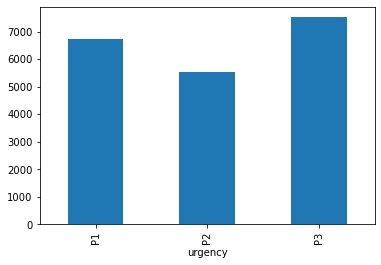

In [3]:
#visualizing the distribution of target variable
df.groupby('urgency').size().plot.bar()
print(df.groupby('urgency').size())

In [4]:
#there are ennough rows for each ticket type, and thus can be considered as balanced dataset. 

In [5]:
#TF-IDF vectorization: converting text data to numeric 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

corpus = df['body'].values

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
X

<19796x9099 sparse matrix of type '<class 'numpy.float64'>'
	with 464014 stored elements in Compressed Sparse Row format>

In [6]:
df_ML = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_ML['Priority'] = df['urgency']
print(df_ML.shape)
df_ML.head()

(19796, 9100)


,ab,abandon,abandoned,abc,abeam,abilities,ability,able,abnormal,abnormally,...,zig,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,Priority
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2


In [7]:
#Dimension reduction of features
from sklearn.decomposition import PCA
response = df_ML.columns[-1]
features = df_ML.columns[:-1]
y = df_ML[response].values
X = df_ML[features].values

Text(0, 0.5, '% variance explained')

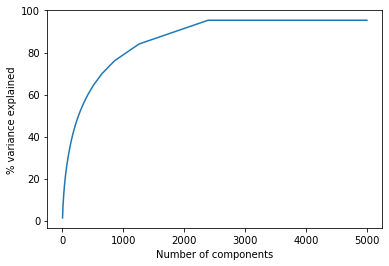

In [11]:
#trying out 5000 maximum principal component
NumComponents = 5000
pca = PCA(n_components=NumComponents)
pca_fit = pca.fit(X)
reduced_X = pca_fit.transform(X)
var_explain_cum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
df_var = pd.DataFrame({'x': np.arange(1,5001,1), 
                      'y': var_explain_cum})

plt.plot(df_var['x'], df_var['y'])
plt.xlabel('Number of components')
plt.ylabel('% variance explained')

In [12]:
df_var.loc[df_var['y']==np.max(df_var['y'])]

,x,y
2386,2387,95.36
2387,2388,95.36
2388,2389,95.36
2389,2390,95.36
2390,2391,95.36
...,...,...
4995,4996,95.36
4996,4997,95.36
4997,4998,95.36
4998,4999,95.36


In [10]:
#from the chart above, we see that saturation occurs around 2400 principal components, at which 95% variance was explained.
# Hence choosing 2400 principal components allows us to reduce the total number of columns from the originally 9099 feature columns

In [14]:
ReducedComponents = 2400
pca_2 = PCA(n_components=ReducedComponents)
pca_fit_2 = pca_2.fit(X)
reduced_X = pca_fit_2.transform(X)

In [16]:
X = reduced_X
Predictors=pd.Series(['PC']*ReducedComponents).str.cat(pd.Series(range(1,ReducedComponents+1)).apply(str)).values
Predictors

array(['PC1', 'PC2', 'PC3', ..., 'PC2398', 'PC2399', 'PC2400'],
      dtype=object)

In [17]:
#standardization/preparation of the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
PredictorScaler=MinMaxScaler() 
PredictorScalerFit=PredictorScaler.fit(X)
X=PredictorScalerFit.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13857, 2400)
(13857,)
(5939, 2400)
(5939,)


In [18]:
#training ML classification models
#Naive Bayes model: GaussianNB is preferred in Binomial Classification, MultinomialNB is preferred in multi-class classification
from sklearn.naive_bayes import GaussianNB, MultinomialNB
clf_NB = GaussianNB()
y_pred_NB = clf_NB.fit(X_train, y_train).predict(X_test)
df_NB = pd.DataFrame(X_test, columns=Predictors)
df_NB['Actual'] = y_test
df_NB['Prediction'] = y_pred_NB
df_NB.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2393,PC2394,PC2395,PC2396,PC2397,PC2398,PC2399,PC2400,Actual,Prediction
0,0.170558,0.305704,0.320970,0.377645,0.300440,0.512070,0.328977,0.475587,0.417384,0.370245,...,0.484445,0.506587,0.491608,0.463133,0.456826,0.444785,0.457674,0.457422,P2,P3
1,0.059201,0.601946,0.716625,0.346003,0.197000,0.510065,0.323403,0.371535,0.366961,0.375005,...,0.511954,0.517759,0.532061,0.437250,0.453367,0.406826,0.468450,0.474043,P1,P1
2,0.169765,0.369158,0.204437,0.341261,0.279360,0.344128,0.309593,0.537349,0.394151,0.405068,...,0.518557,0.476271,0.541513,0.419214,0.435182,0.397477,0.467023,0.466151,P1,P1
3,0.163876,0.341312,0.193034,0.424293,0.302156,0.433852,0.399580,0.560354,0.423645,0.362899,...,0.532940,0.541031,0.502824,0.455795,0.425385,0.424898,0.441593,0.476013,P1,P2
4,0.192141,0.266889,0.231490,0.357927,0.278806,0.429476,0.451059,0.565867,0.436759,0.322583,...,0.522822,0.571892,0.646467,0.270331,0.392762,0.445125,0.377375,0.541406,P1,P3


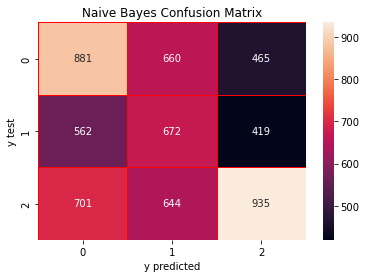

In [19]:
#visualizing prediction results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def plot_cm(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, lw=0.7, linecolor='red', fmt='g')
    plt.title(model+' Confusion Matrix')
    plt.xlabel('y predicted')
    plt.ylabel('y test')
plot_cm(y_test, y_pred_NB, 'Naive Bayes')

In [20]:
# Printing the Overall Accuracy of the model
from sklearn import metrics
F1_Score=metrics.f1_score(y_test, y_pred_NB, average='weighted')
print('Accuracy of NB model on Testing Sample Data:', round(F1_Score,2))

Accuracy of NB model on Testing Sample Data: 0.42


Accuracy of the LR model on Testing Sample Data: 0.72


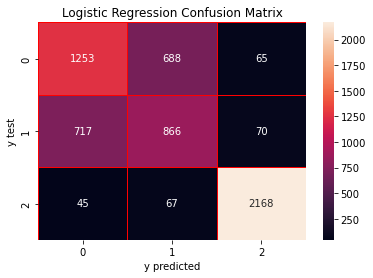

In [21]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(C=5, penalty='l2', solver='newton-cg')
y_pred_LR = clf_LR.fit(X_train, y_train).predict(X_test)
df_LR = pd.DataFrame(X_test, columns=Predictors)
df_LR['Actual'] = y_test
df_LR['Prediction'] = y_pred_LR

F1_Score=metrics.f1_score(y_test, y_pred_LR, average='weighted')
print('Accuracy of the LR model on Testing Sample Data:', round(F1_Score,2))

plot_cm(y_test, y_pred_LR, 'Logistic Regression')

In [18]:
#other ML models, like decision trees, random forest, XGBoost were trained to this dataset, but painfully slow.
#we will use LR model (at the reasonable accurcy of 73%) to predict the priority of incoming tickets.

In [22]:
#training the best model on full data
FinalModel = clf_LR.fit(X, y)

In [25]:
# Defining a function which converts words into numeric vectors for prediction
def FunctionPredictUrgency(inpText):
    
    # Using the same vectorizer converting the text to numeric vector
    X=vectorizer.transform(inpText)
    #print(X.toarray())
 
    # calculating the principal components
    reduced_X = pca_fit_2.transform(X.toarray())
    
    # If standardization/normalization was done on training
    # then the above X must also be converted to same platform
    # Generating the normalized values of X
    X=PredictorScalerFit.transform(reduced_X)
    
    # Generating the prediction using Naive Bayes model and returning
    Prediction=FinalModel.predict(X)
    Result=pd.DataFrame(data=inpText, columns=['Text'])
    Result['Prediction']=Prediction
    return(Result)

In [26]:
# Calling the function
NewTicket=["system down please restart it", "Please help to resolve system issue","Hello how are you?"]
PredictionResults=FunctionPredictUrgency(inpText=NewTicket)
PredictionResults

,Text,Prediction
0,system down please restart it,P1
1,Please help to resolve system issue,P1
2,Hello how are you?,P3


In [27]:
# Saving the results as a csv file
PredictionResults.to_csv('PredictionResults.csv',index=False)